In [1]:
import collections
import pathlib
import random
import pickle
from typing import Dict, Tuple, Sequence

import cv2
from skimage.color import rgb2lab, lab2rgb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io
from skimage import color

import mahotas
import mahotas.demos
from pylab import gray, imshow, show



import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time

from torchvision.transforms import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import glob
import random
from torch.utils.data import Dataset
from PIL import Image
import sys
import torch
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter


import torchvision
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#Extracting the palette

#Reading Paintings
path = '/Users/arpit/Desktop/GAN/Paintings100/*.jpg'
filenames = [img for img in glob.glob(path)]
filenames.sort()
#Reading Generated Paintings
path_1 = '/Users/arpit/Desktop/GAN/GeneratedPaintings100/*.png'
filenames_1 = [img for img in glob.glob(path_1)]
filenames_1.sort()
# Monet Palette
mp_palette = []
for name in filenames:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Monet Palette Dominant color is: BGR ({})'.format(centers[0].astype(np.int32)))
    mp_palette.append(centers[0].astype(np.int32))
    
#Generated Monet Palette
gen_palette = []
for name in filenames_1:
    img = cv2.imread(name,cv2.IMREAD_UNCHANGED)
    data = img.reshape((-1, 3))
    data = np.float32(data)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv2.KMEANS_RANDOM_CENTERS
    compactness,labels,centers = cv2.kmeans(data,1,None,criteria,10,flags)

    #print('Generated Monet Palette Dominant color is: BGR({})'.format(centers[0].astype(np.int32)))
    gen_palette.append(centers[0].astype(np.int32))
rgb_pal = [i[[2,1,0]] for i in mp_palette]
X = [i/255 for i in rgb_pal]

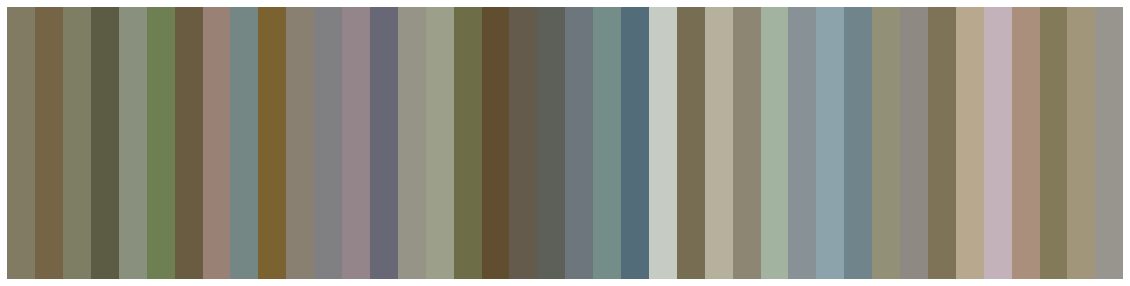

In [3]:
#Palette
scaled_colours = [[color / 255 for color in row] for row in rgb_pal]
#scaled_colours = [[color for color in row] for row in X]
fig, ax = plt.subplots(figsize=(20, 5))
title = "Palette"
#creating bar image
cols = len(scaled_colours)
rows = max([1,int(cols/2.5)])

# Create color Array
barFullData = np.tile(scaled_colours, (rows,1)).reshape(rows, cols, 3)
# Create Image from Array
barImg = Image.fromarray(barFullData, 'RGB')


ax.axis(xmin=0, xmax=len(barFullData))
ax.axis('off')
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for index, colour in enumerate(scaled_colours):
    ax.axvspan(index, index + 1, color=colour)
    ax.patch.set_visible(False)

/Users/arpit/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


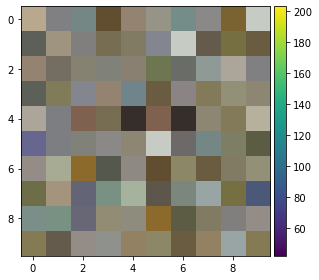

In [4]:
m, n = 10, 10
temp_p = np.array(rgb_pal)
indices = np.random.randint(0, len(temp_p), size=(m, n))
io.imshow(temp_p[indices])

In [5]:
from functools import partial
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.InstanceNorm2d(out_channels))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
    
class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [6]:
class FeatureEncoder(nn.Module):
    def __init__(self):
        super(FeatureEncoder, self).__init__()

        # convolutional
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.norm1_1 = nn.InstanceNorm2d(64)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # residual blocks
        self.res1 = ResNetLayer(64, 128, block=ResNetBasicBlock, n=1)
        self.res2 = ResNetLayer(128, 256, block=ResNetBasicBlock, n=1)
        self.res3 = ResNetLayer(256, 512, block=ResNetBasicBlock, n=1)
    
    def forward(self, x):
        x = F.relu(self.norm1_1(self.conv1_1(x)))
        c4 = self.pool1(x)
        #print('Feature Encoder C4: ', c4.shape)
        c3 = self.res1(c4)
        #print('Feature Encoder C3: ', c3.shape)
        c2 = self.res2(c3)
        #print('Feature Encoder C2: ', c2.shape)
        c1 = self.res3(c2)
        #print('Feature Encoder C1: ', c1.shape)
        return c1, c2, c3, c4

In [1191]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.InstanceNorm2d(out_channels),
    ) 
class RecoloringDecoder(nn.Module):
    # c => (bz, channel, h, w)
    # [Pt, c1]: (18 + 512) -> (256)
    # [c2, d1]: (256 + 256) -> (128)
    # [Pt, c3, d2]: (18 + 128 + 128) -> (64)
    # [Pt, c4, d3]: (18 + 64 + 64) -> 64
    # [Illu, d4]: (1 + 64) -> 3

    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up_4 = double_conv(300 + 512, 256)
        self.dconv_up_3 = double_conv(256 + 256, 128)
        self.dconv_up_2 = double_conv(300 + 128 + 128, 64)
        self.dconv_up_1 = double_conv(300 + 64 + 64, 64)
        self.conv_last = nn.Conv2d(1 + 64, 3, 3, padding=1) 
        
        
    def forward(self, c1, c2, c3, c4, target_palettes_1d, illu):
        bz, h, w = c1.shape[0], c1.shape[2], c1.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 ", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:2 ", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:3 ", target_palettes.shape )

        # concatenate target_palettes with c1
        x = torch.cat((c1.float(), target_palettes.float()), 1)
        #print('X1 shape after Cat C1:', x.shape)
        x = self.dconv_up_4(x)
        #print('X1 shape after deconv C1:', x.shape)
        x = self.upsample(x)
        #print('X1 shape after upsample C1:', x.shape)

        # concatenate c2 with x
        x = torch.cat([c2, x], dim=1)
        #print('X2 shape after Cat C2:', x.shape)
        x = self.dconv_up_3(x)
        #print('X2 shape after deconv C2:', x.shape)
        x = self.upsample(x) 
        #print('X2 shape after upsample C2:', x.shape)

        # concatenate target_palettes and c3 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 for c3", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:reshape and mul pal for c3", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:reshape for c3", target_palettes.shape )
        x = torch.cat([target_palettes.float(), c3, x], dim=1)   
        #print('X1 shape after Cat C3:', x.shape)
        x = self.dconv_up_2(x)
        #print('X1 shape after deconv C3:', x.shape)
        x = self.upsample(x)  
        #print('X1 shape after upsample C3:', x.shape)

        # concatenate target_palettes and c4 with x
        bz, h, w = x.shape[0], x.shape[2], x.shape[3]
        target_palettes = torch.ones(bz, 300, h, w).float().to(device)
        #print("Target Palette Shape:1 for c4", target_palettes.shape )
        target_palettes = target_palettes.reshape(h, w, bz * 300) * target_palettes_1d
        #print("Target Palette Shape:reshape and mul pal for c4", target_palettes.shape )
        target_palettes = target_palettes.permute(2, 0, 1).reshape(bz, 300, h, w)
        #print("Target Palette Shape:reshape for c4", target_palettes.shape )
        x = torch.cat([target_palettes.float(), c4, x], dim=1) 
        #print('X1 shape after Cat C4:', x.shape)
        x = self.dconv_up_1(x)
        #print('X1 shape after deconv C4:', x.shape)
        x = self.upsample(x)  
        #print('X1 shape after upsample C4:', x.shape)

        
        
        #print(x.shape)
        #May be error
        #print('Before illu shape: ',illu.shape)
        illu = illu.view(1, 1,illu.size(1),illu.size(0) )
        #print('After illu shape: ',illu.shape)
        x = torch.cat((x, illu), dim = 1)
        #print('X shapen with x and illu: ',illu.shape)
        x = self.conv_last(x)
        #print('X shape with x: ',x.shape)
        return x

In [1192]:
temp_six = np.array(rgb_pal)

In [1193]:
def rgb2lab(rgb):
    return cv2.cvtColor(rgb, cv2.COLOR_RGB2Lab)


def lab2rgb(lab):
    return cv2.cvtColor(lab, cv2.COLOR_Lab2RGB)

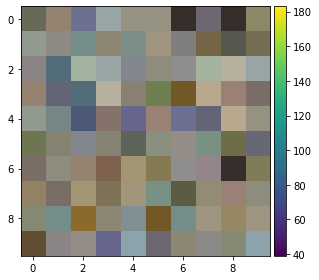

In [1194]:
m, n = 10, 10
indices = np.random.randint(0, len(temp_six), size=(m, n))
io.imshow(temp_six[indices])

In [1195]:
t_lab = []
for i in temp_six:
    t_lab.append(cv2.cvtColor(np.uint8([[i]]), cv2.COLOR_RGB2LAB)[0][0])

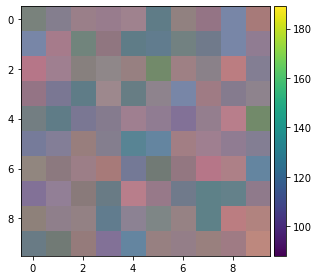

In [1196]:
m, n = 10, 10
lab_f= np.array(t_lab)
indices = np.random.randint(0, len(lab_f), size=(m, n))
io.imshow(lab_f[indices])

In [1197]:
t_rgb = []
for i in t_lab:
    t_rgb.append(cv2.cvtColor(np.uint8([[i]]), cv2.COLOR_LAB2RGB)[0][0])

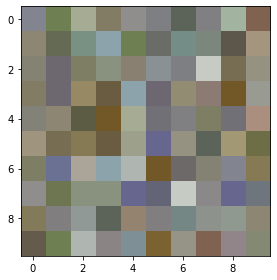

In [1198]:
m, n = 10, 10
tt = np.array(t_rgb)
indices = np.random.randint(0, len(tt), size=(m, n))
io.imshow(tt[indices])

In [772]:
palettet = lab_f.reshape((1, 6, 3))

In [776]:
palettet.flatten()

array([132, 126, 142, 110, 130, 148, 133, 123, 142,  97, 124, 142, 151,
       121, 137, 130, 113, 151], dtype=uint8)

In [1199]:
lab_flat = lab_f.flatten()

In [1200]:
flat_pal = torch.from_numpy(lab_flat).double()

In [1201]:
flat_pal.shape

torch.Size([300])

In [1202]:
def get_illuminance(img):
    """
    Get the luminance of an image. Shape: (h, w)
    """
    
    
    #print('Initial: ', img.shape)
    img = img[0]
    #img = img.astype(np.float) * 255
    #plt.imshow('Lab Illu: ', img)
    #print(img.shape)
    img = img.permute(1, 2, 0)  # (h, w, channel) 
    #print('img: no mul ',img)
    img = img.numpy()
    #print(img)
    #print(img.shape)
    #plt.imshow('Lab Illu: ', img*255)
    #print('img: ',img)
    #print('After No Dividing mul 255 : ', img*255)
    img_LAB = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2LAB)
    #print('img LAB: ',img_LAB)
    #plt.imshow(img_LAB)
    #plt.show()
    
    #img_LAB = rgb2lab(img)
    #print('Illuminance in function:',img_LAB.shape)
    img_L = img_LAB[:,:,0]  # luminance  # (h, w)
    #print(img_L)
    return torch.from_numpy(img_L)

In [1203]:
# hyperparameters
bz = 16
epoches = 1000
lr = 0.0002

In [1204]:
# create model, criterion and optimzer
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(list(FE.parameters()) + list(RD.parameters()), lr=lr, weight_decay=4e-3)

In [1205]:
def augment_image(img, hue_shift):
    # plt.imshow(img)
    # plt.title(f"Original {title} (in RGB)")
    # plt.show()
    img = img[0].permute(1, 2, 0)
    img=img.double()
    img=img.numpy()
    # RGB -> HSV -> hue-shift 
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1

    new_img = matplotlib.colors.hsv_to_rgb(img_HSV)
    #print('NI SHape',new_img.shape)
    #plt.imshow(new_img)
    #plt.title(f"New HSV to rgb (in RGB)")
    #plt.show()

    # fixed original luminance
    img = img.astype(np.float32) 
    #plt.imshow(img)
    #plt.title("IMG")
    #plt.show()
    new_img = new_img.astype(np.float32) 
    #plt.imshow(new_img)
    #plt.title("New IMG")
    #plt.show()
    
    
    
    #----------------------------------------------------#
    #check here
    #----------------------------------------------------#
  
    
    ori_img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    #plt.imshow(ori_img_LAB)
    #plt.title("IMG")
    #plt.show()
    new_img_LAB = cv2.cvtColor(new_img, cv2.COLOR_RGB2LAB)
    #plt.imshow(new_img_LAB)
    #plt.title("NEW IMG")
    #plt.show()
    
    
 
    
    #ori_img_LAB = rgb2lab(img)
    #new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    #new_im = cv2.cvtColor(np.float32(new_img_LAB), cv2.COLOR_LAB2RGB)
    #plt.imshow(new_im)
    #plt.title("RGB IMG")
    #plt.show()




    #new_img_augmented = new_im
    #plt.imshow(new_img_augmented)
    #plt.title(f"New {title} (in RGB) with Fixed Luminance")
    #plt.show()
    #plt.close()
    #print(new_img_augmented.shape)
    new_img_augmented =  np.transpose(new_img_LAB, (2,0,1))
    return new_img_augmented

In [1206]:
# pre-processsing
transform = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

In [1207]:
cifar_data = torchvision.datasets.CIFAR10(root="data", download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(cifar_data,
                                          batch_size=1,
                                          shuffle=True,
                                          )

Files already downloaded and verified


In [1208]:
!ls

FE_RD.pth        Untitled.ipynb   slurm-43512.out  temp-B
PaletteNet.ipynb data             slurm-43543.out
Temp.ipynb       jupyter.sh       temp-A


In [1209]:
dataset = datasets.ImageFolder('temp-A/', transform=transform)
dataset_1 = datasets.ImageFolder('temp-B/', transform=transform)

In [1210]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
dataloader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=1, shuffle=True)

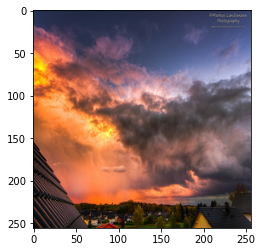

In [1211]:
for images, labels in dataloader:
    plt.imshow(images[0].permute(1,2,0))
    break

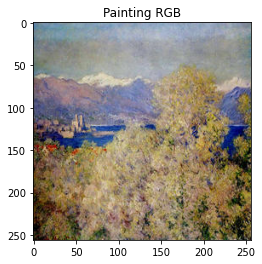

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


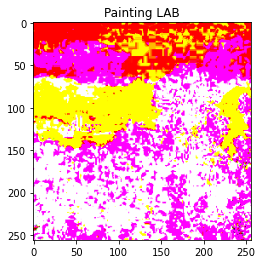

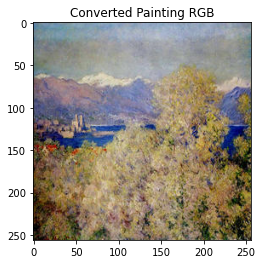

In [1212]:
for images, labels in dataloader_1:
    plt.imshow(images[0].permute(1,2,0))
    plt.title('Painting RGB')
    plt.show()
    new_im = cv2.cvtColor(np.float32(images[0].permute(1,2,0)), cv2.COLOR_RGB2LAB)
    plt.imshow(new_im)
    plt.title('Painting LAB')
    plt.show()
    new_im = cv2.cvtColor(new_im, cv2.COLOR_LAB2RGB)
    plt.imshow(new_im)
    plt.title('Converted Painting RGB')
    plt.show()
    break

In [1213]:
hue_shift = random.random()

In [1236]:
# train FE and RD
min_loss = float('inf')
for e in range(epoches):
    total_loss = 0.
    for image, label, in tqdm(dataloader):
        #for image_1, label_1, in tqdm(dataloader_1):
        ori_image = image
        #print('image.shape',image.shape)
        new_image = augment_image(image, hue_shift)
        #new_im = new_image
        new_im = torch.from_numpy(new_image)
        #image_1 = image_1.float().to(device)
        #new_img_LAB = cv2.cvtColor(np.float32(image_1.numpy()), cv2.COLOR_RGB2LAB)
        #plt.imshow(new_img_LAB)
        #plt.show()
        illu = get_illuminance(ori_image)
        #print('Illu', illu)
        illu = illu.double()
        #print('Illumination in main: ', illu.shape)
        palette = flat_pal
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        #print('Palette: ',palette.float().to(device))
        #print('Illu:', illu.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))
        #print(out.shape)
        optimizer.zero_grad()


        '''
        plt.imshow(new_im.permute(1,2,0))
        plt.show()
        print(out[0].shape)
        plt.imshow((out[0].permute(1,2,0)).detach().numpy())
        plt.show()
        temp = cv2.cvtColor(np.uint8((out[0].permute(1,2,0)).detach().numpy()), cv2.COLOR_LAB2RGB)
        plt.imshow(temp)
        plt.show()
        loss = criterion(torch.from_numpy(temp).float().to(device), new_im.float().to(device))
        '''


        #print('Out: ',out[0].shape)
        #print('New: ',new_im.shape)

        loss = criterion(out[0], new_im.float().to(device))
        loss.backward()
        optimizer.step()
    total_loss += loss.item()
    print(e, total_loss)

    if total_loss < min_loss:
        min_loss = total_loss
        state = {
            'epoch': e,
            'FE': FE.state_dict(),
            'RD': RD.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, "FE_RD.pth")

100%|██████████| 12/12 [00:29<00:00,  2.47s/it]


0 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

1 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

2 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

3 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

4 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

5 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

6 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

7 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

8 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

9 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

10 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

11 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

12 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

13 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

14 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

15 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

16 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

17 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

18 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

19 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

20 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

21 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

22 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

23 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

24 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

25 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

26 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

27 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

28 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

29 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

30 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

31 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

32 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

33 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

34 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

35 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

36 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

37 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

38 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

39 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

40 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

41 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

42 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

43 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

44 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

45 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

46 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

47 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

48 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

49 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

50 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

51 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

52 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

53 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

54 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

55 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

56 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

57 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

58 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

59 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

60 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

61 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

62 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

63 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

64 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

65 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

66 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

67 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

68 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

69 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

70 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

71 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

72 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

73 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

74 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

75 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

76 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

77 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

78 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

79 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

80 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

81 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

82 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

83 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

84 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

85 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

86 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

87 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

88 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

89 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

90 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

91 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

92 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

93 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

94 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

95 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

96 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

97 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

98 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

99 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

100 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

101 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

102 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

103 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

104 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

105 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

106 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

107 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

108 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

109 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

110 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

111 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

112 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

113 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

114 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

115 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

116 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

117 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

118 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

119 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

120 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

121 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

122 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

123 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

124 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

125 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

126 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

127 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

128 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

129 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

130 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

131 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

132 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

133 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

134 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

135 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

136 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

137 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

138 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

139 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

140 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

141 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

142 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

143 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

144 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

145 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

146 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

147 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

148 396.2029724121094


  0%|          | 0/12 [00:00<?, ?it/s]

149 699.7948608398438


  0%|          | 0/12 [00:00<?, ?it/s]

150 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

151 421.833984375


  0%|          | 0/12 [00:00<?, ?it/s]

152 213.86146545410156


  0%|          | 0/12 [00:00<?, ?it/s]

153 456.4322814941406


  0%|          | 0/12 [00:00<?, ?it/s]

154 482.8419189453125


  0%|          | 0/12 [00:00<?, ?it/s]

155 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

156 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

157 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

158 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

159 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

160 217.6346435546875


  0%|          | 0/12 [00:00<?, ?it/s]

161 276.6960754394531


  0%|          | 0/12 [00:00<?, ?it/s]

162 637.5933227539062


  0%|          | 0/12 [00:00<?, ?it/s]

163 434.5305480957031


  0%|          | 0/12 [00:00<?, ?it/s]

164 167.6072540283203


  0%|          | 0/12 [00:00<?, ?it/s]

165 1232.119384765625


  0%|          | 0/12 [00:00<?, ?it/s]

166 276.6960754394531


100%|██████████| 12/12 [00:30<00:00,  2.47s/it]

KeyboardInterrupt: 

In [1237]:
# load model from saved model file
state = torch.load("FE_RD.pth")
FE = FeatureEncoder().float().to(device)
RD = RecoloringDecoder().float().to(device)
FE.load_state_dict(state['FE'])
RD.load_state_dict(state['RD'])
optimizer.load_state_dict(state['optimizer'])

In [1238]:
for image,label in tqdm(dataloader):
        ori_image = image
        hue_shift = random.random()
        new_image = augment_image(image, hue_shift)
        new_im = torch.from_numpy(new_image)
        illu = get_illuminance(ori_image)
        illu = illu.double()
        palette = flat_pal
        c1, c2, c3, c4 = FE.forward(ori_image.float().to(device))
        out = RD.forward(c1, c2, c3, c4, palette.float().to(device), illu.float().to(device))
        break
        

  0%|          | 0/12 [00:01<?, ?it/s]


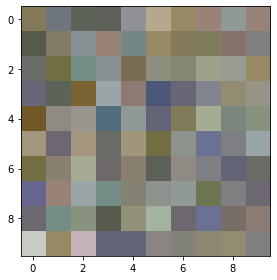

In [1239]:
m, n = 10, 10
tt = np.array(t_rgb)
indices = np.random.randint(0, len(tt), size=(m, n))
io.imshow(tt[indices])

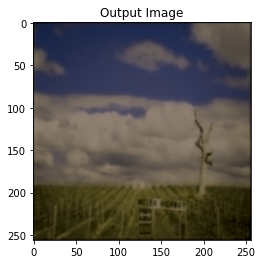

In [1240]:
#out.shape
out = out[0].detach().cpu()
out = out.permute(1,2,0)
out = cv2.cvtColor(np.float32(out), cv2.COLOR_LAB2RGB)
plt.imshow(out)
plt.title("Output Image")
plt.show()

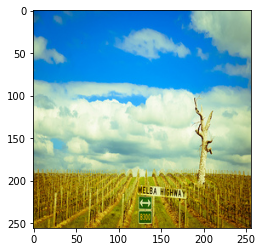

In [1241]:
plt.imshow(ori_image[0].permute(1,2,0))

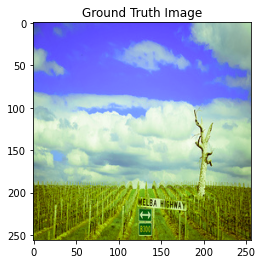

In [1242]:
new_im = new_im.detach().cpu()
new_im = new_im.permute(1,2,0)
new_im = cv2.cvtColor(np.float32(new_im), cv2.COLOR_LAB2RGB)
plt.imshow(new_im)
plt.title("Ground Truth Image")
plt.show()